In [1]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")


In [3]:
query = """select *
        from eigensonne_dwh.public.lead_scoring_sample_1 """
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()


,id,lead_source,lead_medium,lead_campaign,bundesland,closest_team,radius_category,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
0,00Q5J000002qx3WUAQ,Website,None,None,Schleswig-Holstein,hotel,35,24,Regular,1,0,0,14,1
1,00Q5J000002qx7dUAA,Wattfox,affiliate,wattfox-standard,Bayern,echo,35,18,Regular,1,0,0,8,0
2,00Q5J000002qx7jUAA,Wattfox,affiliate,wattfox-standard,Baden-Württemberg,india,35,31,Regular,1,0,0,18,1
3,00Q5J000002qx7JUAQ,Wattfox,affiliate,wattfox-standard,Bayern,echo,75,53,Regular,1,0,0,14,1
4,00Q5J000002qx7TUAQ,Wattfox,affiliate,wattfox-standard,Nordrhein-Westfalen,juliett,35,18,Regular,1,0,0,14,1


In [4]:
# DATA PREPARATION

#checking duplicates
sum(base.duplicated(subset = 'id')) == 0
# No duplicate values

True

In [5]:
print(base.shape)
base.dtypes

(13917, 14)


id                           object
lead_source                  object
lead_medium                  object
lead_campaign                object
bundesland                   object
closest_team                 object
radius_category              object
distance                      int64
record_type_name_c           object
has_opened                    int64
has_clicked_non_photo_url     int64
photo_upload                  int64
duration_photo_upload         int64
has_reached_wfp               int64
dtype: object

In [6]:
#drop data closest team and radius category cause of duplocates
#drop medium too for testing reasons
base=base.drop(['closest_team','radius_category','lead_medium'],1)

In [7]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13917 entries, 0 to 13916
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         13917 non-null  object
 1   lead_source                13643 non-null  object
 2   lead_campaign              12941 non-null  object
 3   bundesland                 13917 non-null  object
 4   distance                   13917 non-null  int64 
 5   record_type_name_c         13917 non-null  object
 6   has_opened                 13917 non-null  int64 
 7   has_clicked_non_photo_url  13917 non-null  int64 
 8   photo_upload               13917 non-null  int64 
 9   duration_photo_upload      13917 non-null  int64 
 10  has_reached_wfp            13917 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 1.2+ MB


In [8]:
base.describe()

,distance,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
count,13917.000000,13917.000000,13917.000000,13917.000000,13917.000000,13917.000000
mean,43.723432,0.677660,0.074872,0.072789,7.323274,0.254006
std,30.009559,0.467389,0.263195,0.259799,9.655062,0.435317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,1.000000,0.000000,0.000000,2.000000,0.000000
75%,60.000000,1.000000,0.000000,0.000000,14.000000,1.000000
max,279.000000,1.000000,1.000000,1.000000,101.000000,1.000000


In [9]:
base.isnull().sum()

id                             0
lead_source                  274
lead_campaign                976
bundesland                     0
distance                       0
record_type_name_c             0
has_opened                     0
has_clicked_non_photo_url      0
photo_upload                   0
duration_photo_upload          0
has_reached_wfp                0
dtype: int64

In [10]:
#see percentage of null values to drop the once >= 70%

round(100*(base.isnull().sum()/len(base.index)), 2)

id                           0.00
lead_source                  1.97
lead_campaign                7.01
bundesland                   0.00
distance                     0.00
record_type_name_c           0.00
has_opened                   0.00
has_clicked_non_photo_url    0.00
photo_upload                 0.00
duration_photo_upload        0.00
has_reached_wfp              0.00
dtype: float64

In [11]:
# we will drop the columns having more than 70% NA values.
data = base.drop(base.loc[:,list(round(100*(base.isnull().sum()/len(base.index)), 2)>70)].columns, 1)

In [12]:
# Now we will take care of null values in each column one by one.
data['lead_source'].describe()

count       13643
unique         26
top       Wattfox
freq         4794
Name: lead_source, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

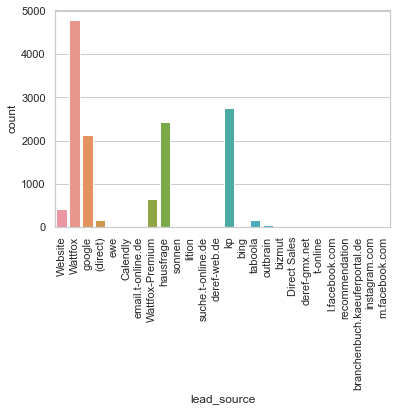

In [13]:
sns.countplot(data['lead_source'])
xticks(rotation = 90)

In [14]:
data.groupby(['lead_source'])['id'].count()

lead_source
(direct)                          166
Calendly                           28
Direct Sales                        2
Wattfox                          4794
Wattfox-Premium                   651
Website                           424
bing                                1
bizmut                              1
branchenbuch.kaeuferportal.de       1
deref-gmx.net                       1
deref-web.de                        1
email.t-online.de                   3
ewe                                 1
google                           2126
hausfrage                        2430
instagram.com                       1
kp                               2757
l.facebook.com                      1
lition                             23
m.facebook.com                      1
outbrain                           51
recommendation                      4
sonnen                             18
suche.t-online.de                   1
t-online                            1
taboola                           155


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

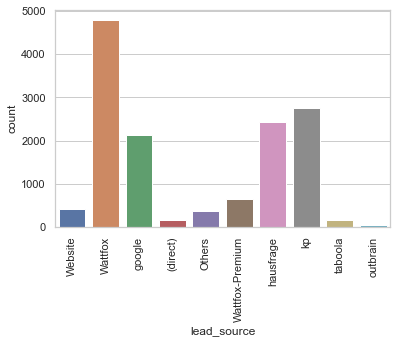

In [15]:
#taking into account that we always knows when leads come from affiliates, we will call the null values and 
#every lead comming from a source with a total of leads < 30 'Other'
data['lead_source'] = data['lead_source'].replace(np.nan, 'Others')
data['lead_source'] = data['lead_source'].replace(data.loc[data.groupby('lead_source').lead_source.transform('count').lt(30),
                               'lead_source'],'Others')

sns.countplot(data['lead_source'])
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75]),
 <a list of 76 Text major ticklabel objects>)

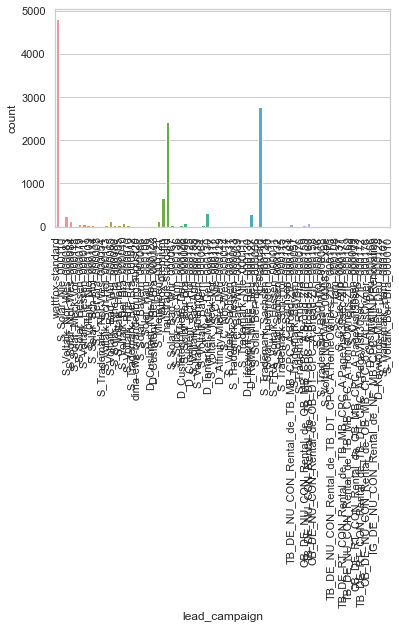

In [16]:
#there are too many different categories that variate too much among each other so this is not reliable
sns.countplot(data['lead_campaign'])
xticks(rotation = 90)

In [17]:
data = data.drop(['lead_campaign'],1)

In [18]:
data['record_type_name_c'].describe()


count       13917
unique          2
top       Regular
freq        11244
Name: record_type_name_c, dtype: object

In [19]:
round(100*(data.isnull().sum()/len(data.index)), 2)

id                           0.0
lead_source                  0.0
bundesland                   0.0
distance                     0.0
record_type_name_c           0.0
has_opened                   0.0
has_clicked_non_photo_url    0.0
photo_upload                 0.0
duration_photo_upload        0.0
has_reached_wfp              0.0
dtype: float64

In [20]:
#Exploratory Data Analytics
# Univariate Analysis 

In [21]:
Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

7.278867572034203

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

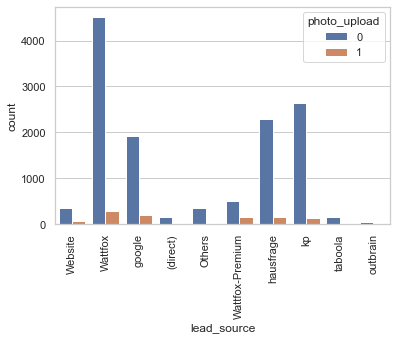

In [22]:
#lead_source 
sns.countplot(x = "lead_source", hue = "photo_upload", data = data)
xticks(rotation = 90)

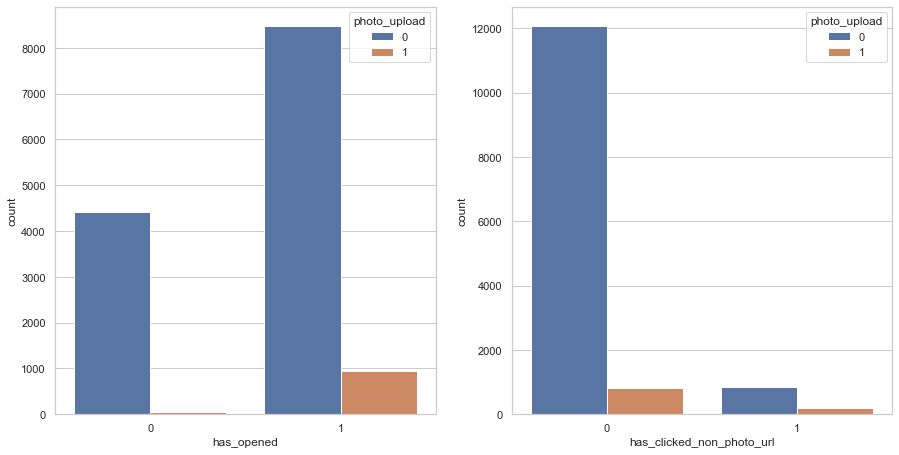

In [24]:
fig, axs = plt.subplots(1,2,figsize = (15,7.5))
sns.countplot(x = "has_opened", hue = "photo_upload", data = data, ax = axs[0])
sns.countplot(x = "has_clicked_non_photo_url", hue = "photo_upload", data = data, ax = axs[1])

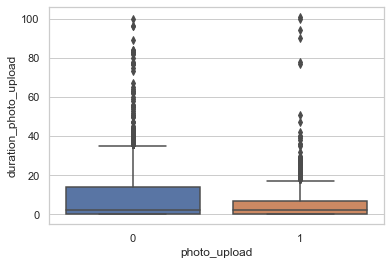

In [25]:
sns.boxplot(y = 'duration_photo_upload', x = 'photo_upload', data = data)

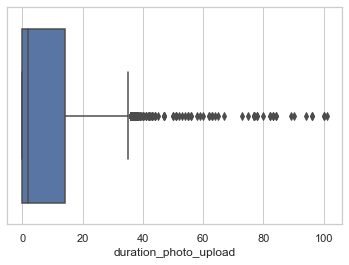

In [26]:
sns.boxplot(data['duration_photo_upload'])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

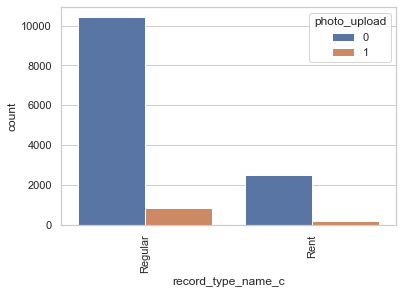

In [27]:
#record_type_name_c 
sns.countplot(x = "record_type_name_c", hue = "photo_upload", data = data)
xticks(rotation = 90)

In [28]:
data.head(10)

,id,lead_source,bundesland,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
0,00Q5J000002qx3WUAQ,Website,Schleswig-Holstein,24,Regular,1,0,0,14,1
1,00Q5J000002qx7dUAA,Wattfox,Bayern,18,Regular,1,0,0,8,0
2,00Q5J000002qx7jUAA,Wattfox,Baden-Württemberg,31,Regular,1,0,0,18,1
3,00Q5J000002qx7JUAQ,Wattfox,Bayern,53,Regular,1,0,0,14,1
4,00Q5J000002qx7TUAQ,Wattfox,Nordrhein-Westfalen,18,Regular,1,0,0,14,1
5,00Q5J000002qx7xUAA,Wattfox,Berlin,14,Regular,0,0,0,40,0
6,00Q5J000002qx8bUAA,Wattfox,Hessen,60,Regular,0,0,0,8,0
7,00Q5J000002qx8lUAA,Wattfox,Nordrhein-Westfalen,30,Regular,1,0,0,15,1
8,00Q5J000002qx9UUAQ,Wattfox,Hessen,13,Regular,1,0,0,14,1
9,00Q5J000002qxaQUAQ,Wattfox,Nordrhein-Westfalen,29,Rent,1,0,0,19,0


In [29]:
# Data Preparation



In [31]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source','bundesland']], drop_first=True)

# first value is dropped because the category variables enter the regression with the logic k-1. 
#For more information see:
#https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables


#dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
#                        columns=['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

dummy1.head()

,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [32]:
# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)
data.head()

,id,lead_source,bundesland,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,00Q5J000002qx3WUAQ,Website,Schleswig-Holstein,24,Regular,1,0,0,14,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00Q5J000002qx7dUAA,Wattfox,Bayern,18,Regular,1,0,0,8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000002qx7jUAA,Wattfox,Baden-Württemberg,31,Regular,1,0,0,18,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000002qx7JUAQ,Wattfox,Bayern,53,Regular,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000002qx7TUAQ,Wattfox,Nordrhein-Westfalen,18,Regular,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [34]:
data = data.drop(['lead_source',	'bundesland',
                             'record_type_name_c'], axis = 1)


In [35]:
data.head(10)

,id,distance,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,00Q5J000002qx3WUAQ,24,1,0,0,14,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00Q5J000002qx7dUAA,18,1,0,0,8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000002qx7jUAA,31,1,0,0,18,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000002qx7JUAQ,53,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000002qx7TUAQ,18,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00Q5J000002qx7xUAA,14,0,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,00Q5J000002qx8bUAA,60,0,0,0,8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,00Q5J000002qx8lUAA,30,1,0,0,15,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,00Q5J000002qx9UUAQ,13,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,00Q5J000002qxaQUAQ,29,1,0,0,19,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [36]:
#train-test split 
# Putting feature variable to X
X = data.drop(['id','photo_upload'], axis=1)
X.head()

,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,24,1,0,14,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,18,1,0,8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31,1,0,18,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,53,1,0,14,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,1,0,14,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [37]:
y = data['photo_upload']

y.head()

0    0
1    0
2    0
3    0
4    0
Name: photo_upload, dtype: int64

In [38]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=None)

In [39]:
#feature scaling
scaler = StandardScaler()

X_train[['distance','duration_photo_upload']] = scaler.fit_transform(
    X_train[['distance','duration_photo_upload']])

X_train.head()

<ipython-input-39-732c84c0a684>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['distance','duration_photo_upload']] = scaler.fit_transform(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
922,-0.326192,1,0,-0.130555,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6207,1.002097,0,0,-0.653776,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9300,0.171917,1,0,0.706598,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6573,-0.027327,0,0,-0.444488,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10635,-0.126948,1,1,0.706598,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [40]:
#How many conversions do we have 

Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

7.278867572034203

In [40]:
#Model building 

In [41]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9710
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1514.4
Date:                Thu, 21 Jan 2021   Deviance:                       3028.8
Time:                        21:04:21   Pearson chi2:                 2.07e+09
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -4.9489      0.425    -11.653      0.000      -5.781      -4.117
distance                             -0.0266      0.065     -0.406      0.685      -0.155       0.102
has_opened                            1.3497      0.169      7.963      0.000       1.018       1.682
has_clicked_non_photo_url             0.8062      0.141      5.731      0.000       0.530       1.082
duration_photo_upload                -1.8220      0.090    -20.269      0.000      -1.998      -1.646
has_reached_wfp                       4.2978      0.140     30.784      0.000       4.024       4.571
record_type_name_c_Rent              -0.6110      0.133     -4.595      0.000      -0.872      -0.350
lead_source_Others                   -1.1967      0.593     -2.017      0.044      -2.360      -0.034
lead_source_Wattfox                  -0.9654      0.394     -2.451      0.014      -1.738      -0.193
lead_source_Wattfox-Premium          -0.9710      0.411     -2.365      0.018      -1.776      -0.166
lead_source_Website                   0.1459      0.434      0.337      0.736      -0.704       0.996
lead_source_google                   -0.3121      0.397     -0.785      0.432      -1.091       0.467
lead_source_hausfrage                -1.2565      0.403     -3.120      0.002      -2.046      -0.467
lead_source_kp                       -1.5838      0.406     -3.899      0.000      -2.380      -0.788
lead_source_outbrain                 -0.1092      0.839     -0.130      0.896      -1.753       1.534
lead_source_taboola                  -0.6089      0.653     -0.933      0.351      -1.889       0.671
bundesland_Bayern                    -0.1865      0.264     -0.705      0.481      -0.705       0.332
bundesland_Berlin                     0.1549      0.262      0.592      0.554      -0.358       0.668
bundesland_Brandenburg               -0.3134      0.199     -1.574      0.115      -0.704       0.077
bundesland_Bremen                   -19.7465   4.01e+04     -0.000      1.000   -7.87e+04    7.87e+04
bundesland_Hamburg                    0.4222      0.366      1.153      0.249      -0.295       1.140
bundesland_Hessen                    -0.5109      0.200     -2.555      0.011      -0.903      -0.119
bundesland_Mecklenburg-Vorpommern    -0.4884      0.566     -0.863      0.388      -1.598       0.621
bundesland_Niedersachsen             -0.1447      0.229     -0.630      0.528      -0.594       0.305
bundesland_Nordrhein-Westfalen       -0.2656      0.147     -1.803      0.071      -0.554       0.023
bundesland_Rheinland-Pfalz           -0.2426      0.233     -1.042      0.297      -0.699       0.213
bundesland_Saarland                 -19.7441   1.57e+04     -0.001      0.999   -3.07e+04    3.07e+04
bundesland_Sachsen     

In [42]:
# feature selection using RFE

logreg = LogisticRegression()

rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe.support_

/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
       False,  True, False, False, False, False, False,  True,  True,
       False, False, False])

In [43]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('distance', False, 16),
 ('has_opened', True, 1),
 ('has_clicked_non_photo_url', True, 1),
 ('duration_photo_upload', True, 1),
 ('has_reached_wfp', True, 1),
 ('record_type_name_c_Rent', True, 1),
 ('lead_source_Others', True, 1),
 ('lead_source_Wattfox', True, 1),
 ('lead_source_Wattfox-Premium', True, 1),
 ('lead_source_Website', True, 1),
 ('lead_source_google', False, 6),
 ('lead_source_hausfrage', True, 1),
 ('lead_source_kp', True, 1),
 ('lead_source_outbrain', False, 5),
 ('lead_source_taboola', False, 12),
 ('bundesland_Bayern', False, 11),
 ('bundesland_Berlin', True, 1),
 ('bundesland_Brandenburg', False, 7),
 ('bundesland_Bremen', False, 15),
 ('bundesland_Hamburg', True, 1),
 ('bundesland_Hessen', False, 2),
 ('bundesland_Mecklenburg-Vorpommern', False, 3),
 ('bundesland_Niedersachsen', False, 14),
 ('bundesland_Nordrhein-Westfalen', False, 9),
 ('bundesland_Rheinland-Pfalz', False, 10),
 ('bundesland_Saarland', True, 1),
 ('bundesland_Sachsen', True, 1),
 ('bundesland_S

In [44]:
col = X_train.columns[rfe.support_]
col

Index(['has_opened', 'has_clicked_non_photo_url', 'duration_photo_upload',
       'has_reached_wfp', 'record_type_name_c_Rent', 'lead_source_Others',
       'lead_source_Wattfox', 'lead_source_Wattfox-Premium',
       'lead_source_Website', 'lead_source_hausfrage', 'lead_source_kp',
       'bundesland_Berlin', 'bundesland_Hamburg', 'bundesland_Saarland',
       'bundesland_Sachsen'],
      dtype='object')

In [45]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9725
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1518.9
Date:                Thu, 21 Jan 2021   Deviance:                       3037.9
Time:                        21:04:54   Pearson chi2:                 2.05e+09
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -5.4610      0.199    -27.391      0.000      -5.852      -5.070
has_opened                      1.3385      0.169      7.929      0.000       1.008       1.669
has_clicked_non_photo_url       0.8022      0.140      5.712      0.000       0.527       1.077
duration_photo_upload          -1.8228      0.090    -20.365      0.000      -1.998      -1.647
has_reached_wfp                 4.2951      0.139     30.949      0.000       4.023       4.567
record_type_name_c_Rent        -0.6209      0.131     -4.732      0.000      -0.878      -0.364
lead_source_Others             -0.8893      0.466     -1.910      0.056      -1.802       0.023
lead_source_Wattfox            -0.6700      0.141     -4.753      0.000      -0.946      -0.394
lead_source_Wattfox-Premium    -0.6697      0.177     -3.779      0.000      -1.017      -0.322
lead_source_Website             0.4203      0.237      1.774      0.076      -0.044       0.885
lead_source_hausfrage          -0.9785      0.166     -5.887      0.000      -1.304      -0.653
lead_source_kp                 -1.3069      0.174     -7.515      0.000      -1.648      -0.966
bundesland_Berlin               0.4187      0.229      1.829      0.067      -0.030       0.868
bundesland_Hamburg              0.6828      0.346      1.973      0.049       0.004       1.361
bundesland_Saarland           -19.5789   1.57e+04     -0.001      0.999   -3.08e+04    3.08e+04
bundesland_Sachsen             -0.5881      0.434     -1.354      0.176      -1.440       0.263
===============================================================================================
"""

In [47]:
col2 = col.drop(['bundesland_Sachsen','bundesland_Saarland'],1)
X_train_sm = sm.add_constant(X_train[col2])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9727
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1520.4
Date:                Thu, 21 Jan 2021   Deviance:                       3040.8
Time:                        21:06:28   Pearson chi2:                 2.00e+09
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -5.4720      0.199    -27.488      0.000      -5.862      -5.082
has_opened                      1.3337      0.169      7.908      0.000       1.003       1.664
has_clicked_non_photo_url       0.8045      0.141      5.724      0.000       0.529       1.080
duration_photo_upload          -1.8197      0.089    -20.363      0.000      -1.995      -1.645
has_reached_wfp                 4.2981      0.139     30.981      0.000       4.026       4.570
record_type_name_c_Rent        -0.6278      0.131     -4.792      0.000      -0.885      -0.371
lead_source_Others             -0.9075      0.468     -1.937      0.053      -1.826       0.011
lead_source_Wattfox            -0.6626      0.141     -4.707      0.000      -0.939      -0.387
lead_source_Wattfox-Premium    -0.6667      0.177     -3.764      0.000      -1.014      -0.320
lead_source_Website             0.4275      0.237      1.806      0.071      -0.036       0.891
lead_source_hausfrage          -0.9745      0.166     -5.869      0.000      -1.300      -0.649
lead_source_kp                 -1.3066      0.174     -7.510      0.000      -1.648      -0.966
bundesland_Berlin               0.4303      0.229      1.880      0.060      -0.018       0.879
bundesland_Hamburg              0.6944      0.346      2.006      0.045       0.016       1.373
===============================================================================================
"""

In [48]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

922      0.434078
6207     0.003786
9300     0.080719
6573     0.009349
10635    0.214849
7818     0.016434
12255    0.041528
786      0.000495
10923    0.001374
3037     0.042029
dtype: float64

In [49]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.43407765, 0.00378565, 0.08071873, 0.00934861, 0.21484896,
       0.01643353, 0.04152785, 0.00049517, 0.0013736 , 0.0420291 ])

In [50]:
#
y_train_pred_final = pd.DataFrame({'photo_upload':y_train.values, 'photo_upload_prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id
0,1,0.434078,922
1,0,0.003786,6207
2,0,0.080719,9300
3,0,0.009349,6573
4,0,0.214849,10635


In [51]:
#Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted
0,1,0.434078,922,0
1,0,0.003786,6207,0
2,0,0.080719,9300,0
3,0,0.009349,6573,0
4,0,0.214849,10635,0


In [52]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
print(confusion)


[[8958   87]
 [ 371  325]]


In [53]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.predicted))

0.9529822400164254


In [54]:
# Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col2].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# when VIF >5 then multicollinearity in our data is not severe enough to warrant corrective meassures
# to remove structural multicollinearity -> https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

,Features,VIF
0,has_opened,2.65
3,has_reached_wfp,1.76
6,lead_source_Wattfox,1.65
10,lead_source_kp,1.36
9,lead_source_hausfrage,1.35
7,lead_source_Wattfox-Premium,1.33
4,record_type_name_c_Rent,1.25
1,has_clicked_non_photo_url,1.18
2,duration_photo_upload,1.14
8,lead_source_Website,1.06


In [55]:
# metrics beyond simply accuracy
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [56]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.46695402298850575

In [57]:
# Let us calculate specificity
TN / float(TN+FP)

0.9903814262023217

In [58]:
# positive predictive value 
print (TP / float(TP+FP))

0.7888349514563107


In [59]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9602315360703184


In [60]:
#An ROC curve demonstrates several things:

#It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be 
#accompanied by a decrease in specificity).
#The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

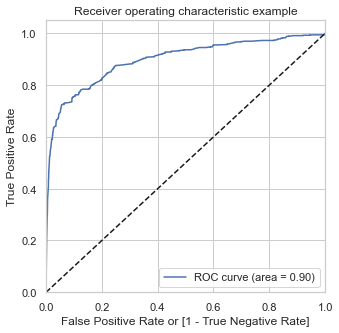

In [61]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.photo_upload, 
                                         y_train_pred_final.photo_upload_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

In [62]:
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.434078,922,0,1,1,1,1,1,0,0,0,0,0
1,0,0.003786,6207,0,1,0,0,0,0,0,0,0,0,0
2,0,0.080719,9300,0,1,0,0,0,0,0,0,0,0,0
3,0,0.009349,6573,0,1,0,0,0,0,0,0,0,0,0
4,0,0.214849,10635,0,1,1,1,0,0,0,0,0,0,0


In [63]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.071451  1.000000  0.000000
0.1   0.1  0.873627  0.771552  0.881481
0.2   0.2  0.930911  0.701149  0.948590
0.3   0.3  0.949287  0.623563  0.974350
0.4   0.4  0.953598  0.543103  0.985185
0.5   0.5  0.952982  0.466954  0.990381
0.6   0.6  0.947233  0.326149  0.995025
0.7   0.7  0.942408  0.228448  0.997347
0.8   0.8  0.936249  0.119253  0.999116
0.9   0.9  0.929781  0.017241  1.000000


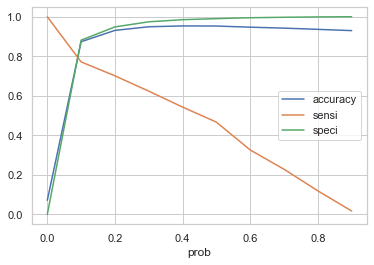

In [64]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [71]:
#### From the curve above, 0.1 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.photo_upload_prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,1,0.434078,922,0,1,1,1,1,1,0,0,0,0,0,1,43
1,0,0.003786,6207,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0.080719,9300,0,1,0,0,0,0,0,0,0,0,0,0,8
3,0,0.009349,6573,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0.214849,10635,0,1,1,1,0,0,0,0,0,0,0,1,21


In [72]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.photo_upload_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,1,0.434078,922,0,1,1,1,1,1,0,0,0,0,0,1,43
1,0,0.003786,6207,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0.080719,9300,0,1,0,0,0,0,0,0,0,0,0,0,8
3,0,0.009349,6573,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0.214849,10635,0,1,1,1,0,0,0,0,0,0,0,1,21


In [73]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7011494252873564

In [74]:
# Let us calculate specificity
TN / float(TN+FP)

0.9485903814262023

In [75]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.05140961857379768


In [76]:
# Positive predictive value 
print (TP / float(TP+FP))

0.5120671563483735


In [77]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9763313609467456


In [78]:
# Precision and recall

#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
confusion

array([[8958,   87],
       [ 371,  325]])

In [79]:
##### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.7888349514563107

In [80]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.46695402298850575

In [81]:
y_train_pred_final.photo_upload, y_train_pred_final.predicted

(0       1
 1       0
 2       0
 3       0
 4       0
        ..
 9736    0
 9737    0
 9738    0
 9739    0
 9740    0
 Name: photo_upload, Length: 9741, dtype: int64,
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 9736    0
 9737    0
 9738    0
 9739    0
 9740    0
 Name: predicted, Length: 9741, dtype: int64)

In [82]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

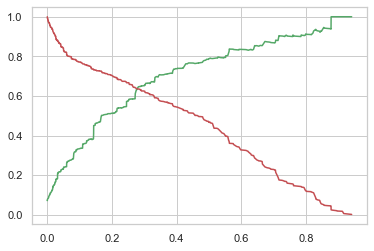

In [83]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [84]:
#Making predictions on the test set

X_test[['distance','duration_photo_upload']] = scaler.fit_transform(X_test[['distance','duration_photo_upload']])

X_train.head()

<ipython-input-84-42eb147c9bee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['distance','duration_photo_upload']] = scaler.fit_transform(X_test[['distance','duration_photo_upload']])
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_google,lead_source_hausfrage,lead_source_kp,lead_source_outbrain,lead_source_taboola,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
922,-0.326192,1,0,-0.130555,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6207,1.002097,0,0,-0.653776,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9300,0.171917,1,0,0.706598,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6573,-0.027327,0,0,-0.444488,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10635,-0.126948,1,1,0.706598,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [85]:
X_test = X_test[col2]
X_test.head()

,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_source_hausfrage,lead_source_kp,bundesland_Berlin,bundesland_Hamburg
8805,0,0,-0.556743,0,0,0,0,0,0,0,1,0,0
9761,1,0,0.658022,0,0,0,0,0,0,0,1,0,0
9337,0,0,0.658022,1,0,0,1,0,0,0,0,0,0
6472,0,0,-0.556743,0,0,0,0,0,0,0,0,0,0
7111,1,1,0.658022,1,1,0,1,0,0,0,0,0,0


In [86]:
X_test_sm = sm.add_constant(X_test)

In [87]:
#maiking predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


8805     0.003124
9761     0.001302
9337     0.045915
6472     0.011443
7111     0.178939
8395     0.031696
10137    0.100088
9603     0.558418
5329     0.032783
10072    0.088733
dtype: float64

In [88]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
8805,0.003124
9761,0.001302
9337,0.045915
6472,0.011443
7111,0.178939


In [89]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,photo_upload,id,0
0,0,8805,0.003124
1,0,9761,0.001302
2,0,9337,0.045915
3,0,6472,0.011443
4,0,7111,0.178939


In [90]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'photo_upload_prob'})

# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['id','photo_upload','photo_upload_prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

,photo_upload,id,photo_upload_prob
0,0,8805,0.003124
1,0,9761,0.001302
2,0,9337,0.045915
3,0,6472,0.011443
4,0,7111,0.178939


In [91]:
y_pred_final['final_predicted'] = y_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,photo_upload,id,photo_upload_prob,final_predicted
0,0,8805,0.003124,0
1,0,9761,0.001302,0
2,0,9337,0.045915,0
3,0,6472,0.011443,0
4,0,7111,0.178939,0


In [92]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.photo_upload, y_pred_final.final_predicted)

0.9202586206896551

In [93]:
confusion2 = metrics.confusion_matrix(y_pred_final.photo_upload, y_pred_final.final_predicted )
confusion2

array([[3621,  238],
       [  95,  222]])

In [94]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [95]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7003154574132492

In [96]:
# Let us calculate specificity
TN / float(TN+FP)

0.9383259911894273